# Get dependencies

In [1]:
!git clone https://github.com/domguia/thinker

Cloning into 'thinker'...
remote: Enumerating objects: 250, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 250 (delta 11), reused 15 (delta 8), pack-reused 230
Receiving objects: 100% (250/250), 1.93 MiB | 17.17 MiB/s, done.
Resolving deltas: 100% (124/124), done.


In [2]:
pip install -q torchinfo lightning torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 32.9 MB/s eta 0:00:00


In [3]:
# pip install torch_xla cloud-tpu-client https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/thinker/lightning_logs/

In [ ]:
%cd /content/thinker

/content/thinker


In [ ]:
# %run th1nker_run_lightning.py

In [ ]:
!git pull

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), 408 bytes | 408.00 KiB/s, done.
From https://github.com/domguia/thinker
   29ce185..3e1d149  main       -> origin/main
Updating 29ce185..3e1d149
Fast-forward
 numbers_data.py | 11 +++++++++++
 1 file changed, 11 insertions(+)


In [ ]:
# pip show torch_xla

In [ ]:
# import torch
# import numpy as np
# import lightning as L
# from torch.utils.data import DataLoader

# from thinker_model import Th1nker, compute_loss, CfgNode
# from toy_model import ToyThinker
# from numbers_data import NumbersComputeDataset

# from torchmetrics.classification import Accuracy

# model_cfg = CfgNode(
#     # hdim = 32,
#     # head_size = 4,
#     # number_of_head= 8,
#     # resid_pdrop = 0.1,
#     # attn_pdrop = 0.1,
#     # bias=False,

#     # vocab_size = 31+1,

#     # input_cache_size = 24,
#     # mem_cache_size = 128,
#     # max_output_len = 24,

#     vocab_size = 31+1,
#     max_latent=64,
#     max_input_len=48,
#     output_len=40,
#     d_model=32,
#     nhead=8,
#     d_hid=32*4,
#     nlayers=1,
#     dropout=0
# )

# data_cfg = CfgNode(batch=2, step=2, max_number=1_000, operations='+-*/', operation_dist=[0,0,1.0,0],
#     in_bases=[16], in_bases_dist=None, # [2,4,8,16] # list(range(2,8+1))
#     out_bases=[16], out_bases_dist=None, # [.1,.2,.3,.4])
# )

# run_cfg = CfgNode(
#     n_latent = 8, # range(4,8)
#     n_step=4, # range(1,4)

#     max_iter=2000,
#     learning_rate=0.005,
#     batch = 1*1024,
# )

# exp_cfg = CfgNode(
#     n_latent = range(4,8+1),
#     n_step = range(1,4+1),
# )

# # define the LightningModule
# class LitTh1nker(L.LightningModule):
#     def __init__(self, model_cfg, run_cfg):
#         super().__init__()
#         self.model = ToyThinker(**model_cfg.__dict__)
#         self.accuracy = Accuracy(task="multiclass", num_classes=model_cfg.vocab_size)
#         self.cfg = run_cfg
#         self.save_hyperparameters(model_cfg.__dict__)
#         self.save_hyperparameters(run_cfg.__dict__)

#     def training_step(self, batch, batch_idx):
#         # training_step defines the train loop.
#         # it is independent of forward
#         inputs, targets = batch
#         inputs, targets = inputs[0], targets[0] # implicit batch trick

#         B, T = inputs.size()

#         n_step = self.cfg.sample('n_step')
#         n_latent = self.cfg.sample('n_latent')

#         n_target = targets.size(1)
#         logits, output_probe = self.model(inputs, n_latent, n_target, n_step)
#         logits, output_probe = logits[:,0,:,:], output_probe[:,0,:,0] # .permute(0,-1,1,2) or (0,3,1,2)

#         # compute loss
#         output_loss = torch.nn.functional.cross_entropy(logits.permute(0,2,1), targets.long())#, ignore_index=20)
#         probe_loss = torch.nn.functional.mse_loss(output_probe, targets.float()/3)


#         loss = output_loss + probe_loss

#         preds = torch.argmax(logits, dim=2)
#         self.log('accuracy', self.accuracy(preds, targets))

#         # Logging to TensorBoard (if installed) by default
#         # self.log("step", B*batch_idx) # for weight and bias
#         self.log("sample", B*batch_idx*1.0)
#         # self.log("batch_idx", batch_idx)
#         self.log("output_loss", output_loss)
#         self.log("outputs_probe_loss", probe_loss)
#         self.log("train_loss", loss)
#         return loss

#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.parameters(), lr=0.005)
#         return optimizer

#     # def forward(self, x):
#     #     return self.model(x)

# # init the autoencoder
# model = LitTh1nker(model_cfg, run_cfg)

# # init data loader
# data_cfg.batch = run_cfg.batch # implicit batch trick
# batch_size = 1

# dataset = NumbersComputeDataset(data_cfg)
# dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=4)

# from lightning.pytorch.callbacks import DeviceStatsMonitor

# # train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
# # gradient_clip_val=0.5, accumulate_grad_batches=1, auto_lr_find=True
# trainer = L.Trainer(
#     limit_train_batches=run_cfg.max_iter,
#     max_epochs=1,
#     # accelerator="tpu", devices=1,
#     # auto_lr_find=True,
#     precision=16,
#     # profiler="simple",
#     callbacks=[DeviceStatsMonitor()]
# )
# # ,precision=16, profiler="simple" | "pytorch"
# trainer.fit(model=model, train_dataloaders=dataloader)

In [ ]:
# model_cfg.sample('n_step')
# isinstance('n_step', str)
# model_cfg.sample

In [ ]:
class CopyDataModule(L.LightningDataModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg

    def setup(self, stage: str):
        self.dataset = Num

    def train_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.cfg.batch)

    def val_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.cfg.batch)

    def test_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.cfg.batch)

    def predict_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.cfg.batch)

    # def teardown(self, stage: str):
    #     # Used to clean-up when the run is finished

NameError: ignored

In [ ]:
# import torch
# torch.__version__

# import torch_xla

In [ ]:
# from lightning.pytorch.tuner import Tuner
# tuner = Tuner(trainer)

# # Run learning rate finder
# lr_finder = tuner.lr_find(model, train_dataloaders=dataloader, num_training=100)

# # Results can be found in
# print(lr_finder.results)

# # Plot with
# fig = lr_finder.plot(suggest=True)
# fig.show()

# # Pick point based on plot, or get suggestion
# new_lr = lr_finder.suggestion()

# # update hparams of the model
# model.hparams.lr = new_lr

# # # Fit model
# # trainer.fit(model)

In [ ]:
# tuner.lr_find?

In [ ]:
# import torch
# torch.cuda.is_bf16_supported()

# # imports the torch_xla package
# import torch_xla
# import torch_xla.core.xla_model as xm

# Start from here

In [1]:
%cd /content/thinker

/content/thinker


In [2]:
# # require by torch.compile on colab
# !export LC_ALL="en_US.UTF-8"
# !export LD_LIBRARY_PATH="/usr/lib64-nvidia"
# !export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
# !ldconfig /usr/lib64-nvidia

In [3]:
# import seaborn as sns
# sns.set_style('dark')
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.style.use('dark_background')

In [4]:
import torch
import numpy as np
from torch.utils.data import DataLoader

# from thinker_model import Th1nker
from utils import CfgNode, plot_loss_and_accuracy, MatchCount, plot_hp_heatmap, loop_over_extremum
from toy_model import ToyThinker
from numbers_data import NumbersComputeDataset, NumbersCopyDataset, TASK_SCHEME

In [5]:
torch.set_printoptions(linewidth=180)

In [6]:
from torch.utils.tensorboard import SummaryWriter

# Create a TensorBoard object
writer = SummaryWriter()

# Set parameters

In [7]:
model_cfg = CfgNode(
    # hdim = 32,
    # head_size = 4,
    # number_of_head= 8,
    # resid_pdrop = 0.1,
    # attn_pdrop = 0.1,
    # bias=False,

    # vocab_size = 31+1,

    # input_cache_size = 24,
    # mem_cache_size = 128,
    # max_output_len = 24,

    vocab_size = 100+1,
    n_probe = 1,
    max_latent=64,
    max_input_len=48,
    output_len=40,
    d_model=16,
    nhead=4,
    d_hid=16*4,
    nlayers=1,
    dropout=0.02,
)
# data_cfg = CfgNode(
#     batch=2,
#     step=2,
#     max_number=1_000,

#     operations='+-*/',
#     operation_dist=[1.0,0,0,0],

#     in_bases=[16], # [2,4,8,16] # list(range(2,8+1))
#     in_bases_dist=None, # [.1,.2,.3,.4])

#     out_bases=[16],
#     out_bases_dist=None,
# )
data_cfg = CfgNode(vocab_size=16, seq_len=30, batch=1, task=None) # , uniform_len=False

run_cfg = CfgNode(
    n_latent = 4, # range(4,8)
    n_step = 1, # range(1,4)

    max_iter=100_000,
    learning_rate=0.01,
    batch = 512,
)

exp_cfg = CfgNode(
    # n_latent = range(4, 8+1),
    # n_step = range(1, 4+1),
    n_latent = [4],
    n_step = [6],
)

In [8]:
# sample(exp_cfg.n_step)
# exp_cfg.sample('n_step')

In [9]:
device = "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("PyTorch device :", device)

# # model = Th1nker(cfg).to(device)
# model = ToyThinker(**model_cfg.__dict__).to(device)

# # model = torch.compile(model)

# import torchinfo
# print(torchinfo.summary(model))

# # Optimizers specified in the torch.optim package
# learning_rate=run_cfg.learning_rate # 0.005

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.0005)
# # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

PyTorch device : cuda:0


In [10]:
generation_base = 16 # @param {type:"number"}

TASK_SCHEME = {
    'input':{ # input base
        'base':{
            'values' : [generation_base], #list(range(2,16+1)), #[2, 4, 10, 16], # 32, 64, 128, 256],
            'distribution' : None, # [0.1, 0.2, 0.3, 0.4], # sampling distribution probability
        },
        'max_length' : 20, # input max lenght after tokenisation
        'overflow_strategy' : 'increase_base',
    },
    'output': { # input base
        'base':{
            'values' : [generation_base], # list(range(2,16+1)), #[2, 4, 10, 16],
            'distribution' : None, # [0.1, 0.2, 0.3, 0.4],
        },
        'max_length' : 20
    },
    'tasks': {
        'add_mult_generator':{
            'task_id': ':fact',
            'step': [2,3],
            'operations': '+-*/',
            'operation_dist':[1,.0,.0,.0],
        },
        'factorize_generator':{
            'task_id': ':fact',
            'step': [2,10], # should sample value in the given range
            'n_first_prime': 100,
        },
        'shared_args':{
            'batch': 2,
            'max_number': 1e15, #1_000_000,
            'task_probabilities': [1.0,0.0],
        }
    }
}

In [11]:
NumbersCopyDataset.count

0

In [12]:
from torch.utils.data import IterableDataset, DataLoader

class NumbersCopyDataset(IterableDataset):
    count = 0
    accuracy = 0
    challenge_factor = 0
    raw_acc = 0
    target_len = 1

    def __init__(self, vocab_size, seq_len, batch, uniform_len=False, task=None):
        self.vocab_size = vocab_size
        self.batch = batch
        self.seq_len = seq_len
        # task
        self.uniform_len = uniform_len
        self.task = task

    @classmethod
    def update_accuracy(cls, raw_acc):
        cls.raw_acc = raw_acc
        # print('update_accuracy ->', cls.raw_acc, raw_acc)

    @classmethod
    def update_challenge_factor(cls, challenge_factor):
        cls.challenge_factor = challenge_factor

    @classmethod
    def get_challenge_factor(cls):
        return cls.challenge_factor

    @classmethod
    def reset(cls, count=0, target_len=1):
        cls.count = count
        cls.target_len = target_len

    @classmethod
    def incr(cls, count=1):
        cls.count += count

    @classmethod
    def get_dist(cls, count=0):
        cls.count = count

    def __iter__(self):
        seq_len, batch = self.seq_len, self.batch
        while True:
            NumbersCopyDataset.incr(batch)
            factor = NumbersCopyDataset.get_challenge_factor()

            # accuracy = NumbersCopyDataset.accuracy
            # target_len = accuracy*seq_len
            raw_acc = NumbersCopyDataset.raw_acc
            target_len = NumbersCopyDataset.target_len
            if raw_acc > 0.85:
               target_len += 0.05
               if target_len > seq_len: target_len = seq_len

            # print('raw_acc:', raw_acc)
            # print('target_len:', target_len)
            # print('cls.target_len:',NumbersCopyDataset.target_len)
            NumbersCopyDataset.target_len = target_len
            NumbersCopyDataset.update_challenge_factor(target_len/seq_len)

            x = torch.randint(0, self.vocab_size, (batch, seq_len))

            if 'progressive_copy' == self.task:
                mask_target_len = seq_len - target_len # * 1.1
                # :-) basic implementation of prgoressive/currilum learning
                # print('mask_target_len',mask_target_len)

                # build mask
                # _, mu, _ -> 0, target_len, seq_len
                s = torch.normal(0, 1, (batch,))
                min_s = min(s)
                s = (s-min_s) / (max(s)-min_s)
                s = s * mask_target_len * 2
                s = torch.clip(s, 0, seq_len-1)
                mask_len = s.int() - 1
                # mask_len = torch.randint(0, seq_len-3, (batch,)) # uniform generation
                mask = torch.arange(seq_len)[None,:].expand(batch, -1) > mask_len[:,None]

                # m = mask_len.min()
                # if m<3: print("-"*20, f"min len mask:{m}")

                x = torch.where(mask, x, 0)
                y = x # just copy
            # run tasks
            if None == self.task:
                y = x #.clone()
            if 'sort' == self.task:
                y = x.sort(dim=1)[0]
            if 'flip' == self.task:
                y = x.flip(dims=(1,))
            if 'roll' == self.task:
                y = torch.Tensor(np.apply_along_axis(lambda a: np.roll(a, a[0]), 1, x))
                # y = x.roll(x[0].item(), 0) # for non batched
            if 'roll_num' == self.task:
                y = (x + x[:,0]) % self.high
            if 'jump' == self.task:
                idx = x[:,0]
                for i in range(16): # max 16 jumps
                    idx += x[:, idx]
                jump = x[:,0] # number of jump
                y = idx[:, jump]
            if 'cumsum' == self.task:
                # y = x.clone()
                # for i in range(x.size(1)):
                #     y[:,i:] = (y[:,i:] + y[i:,i]) % self.high # faster that position base flip
                y = torch.cumsum(x, dim=1) % self.vocab_size
            yield x, y

In [13]:
# data_cfg = CfgNode(batch=2, step=2, max_number=1000, operations='+-*/', operation_dist=[1.0,0,0,0],
#     in_bases=[16], in_bases_dist=None, # [2,4,8,16] # list(range(2,8+1))
#     out_bases=[16], out_bases_dist=None, # [.1,.2,.3,.4])
# )
# dataset = NumbersComputeDataset(data_cfg)

data_cfg = CfgNode(vocab_size=16, seq_len=40, batch=10, task='progressive_copy')
dataset = NumbersCopyDataset(**data_cfg.__dict__)

inputs, targets = next(iter(dataset))
inputs, targets

NumbersCopyDataset.reset()
# NumbersCopyDataset.target_len = 0.1
accuracy = .95
for i, (inputs, targets) in enumerate(dataset):
  print(targets)

  NumbersCopyDataset.update_accuracy(accuracy)

  factor =  NumbersCopyDataset.get_challenge_factor()
  count, challenge_factor, raw_acc, target_len = NumbersCopyDataset.count, NumbersCopyDataset.challenge_factor, NumbersCopyDataset.raw_acc, NumbersCopyDataset.target_len
  print(""
    f"count: {count}, "
    f"challenge_factor: {challenge_factor}, "
    f"raw_acc: {raw_acc}, "
    f"target_len: {target_len}"
    "\n"
  )

  if i > 5: break


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 15],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4, 10, 13,  8,  3,  6, 11, 14, 13,  4, 13, 11,  3, 10,  2,  5, 10,  4,  9,  0, 10,  1,  2, 15,  2,  1, 11, 14,  1,  3],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9],
        [ 5,  3,  6, 10, 15,  1,  7,  5, 12, 15,  6, 15, 14, 11, 13,  8, 15, 14, 12, 13,  7,  7,  8,  6,  8,  7, 10, 14,  1, 14,  1,  7,  9, 14, 10,  1,  9,  3,  8, 15],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11,  6,  0,  4,  8,  8,  3,  2, 11,  9,  2, 13, 14, 11,  1,  1, 11,  9, 11,  8],
        [ 0,  0,  0,  0,  9,  3,  7, 11,  5, 15, 11, 12,  0, 12,  8,  0,  0,  2, 14, 14, 11,  4,  4,  2,  4,  0,  3,  4,  9,  6, 11, 15,  1,  1,  8, 1

In [14]:
# logs1 # logs1 = logs.copy()
# logs2 = logs.copy()

In [15]:
# NumbersCopyDataset.count, NumbersCopyDataset.challenge_factor, NumbersCopyDataset.accuracy, NumbersCopyDataset.target_len

In [16]:
logs = []

# run training

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def plot_loss_and_accuracy(logs, experiment=None, title=None, ax=None, y_log=False):
    # Create a DataFrame from the list of dictionaries.
    if isinstance(logs, pd.DataFrame): df = logs
    else: df = pd.DataFrame(logs)

    # Filter current experiment
    if 'experiment' in df.columns:
        if experiment is None:
            experiment = df.iloc[-1].experiment
        df = df[df.experiment == experiment]

    if ax is None: fig, ax = plt.subplots()

    # Plot the loss values on the left y-axis.
    sns.lineplot(data=df, x=df.index, y='loss', color='red', alpha=.1, ax=ax) #, hue='step')
    sns.lineplot(data=df, x=df.index, y=df.loss.rolling(100).mean(), label='loss', color='red', linewidth=.3, ax=ax)
    if 'factor' in df.columns:
        loss_factor = df.loss*df.factor
        sns.lineplot(data=df, x=df.index, y=loss_factor,  color='darkorange', alpha=.1, ax=ax)
        sns.lineplot(data=df, x=df.index, y=loss_factor.rolling(100).mean(), label='loss * weight', color='darkorange', ax=ax)
    # sns.lineplot(data=df, x='iteration', y='probe_loss', color='peru', ax=ax)
    ax.set_ylabel('Loss')
    if y_log: plt.yscale('log',base=2)

    # Plot the accuracy values on the right y-axis.
    ax2 = ax.twinx()
    sns.lineplot(data=df, x=df.index, y='accuracy', color='purple', alpha=.1, ax=ax2)
    sns.lineplot(data=df, x=df.index, y=df.accuracy.rolling(100).mean(), label='accuracy * weight', color='purple',  ax=ax2)
    if 'raw_acc' in df.columns:
        sns.lineplot(data=df, x=df.index, y='raw_acc',  color='violet',  alpha=.1, ax=ax2)
        sns.lineplot(data=df, x=df.index, y=df.raw_acc.rolling(100).mean(),  label='raw accuracy',  color='violet', linewidth=.3, ax=ax2)

    if 'factor' in df.columns:   sns.lineplot(data=df, x=df.index, y='factor',   label='difficulty weight',   color='gray', ax=ax2)

    if 'loss_std' in df.columns: sns.lineplot(data=df, x=df.index, y='loss_std', label='loss_std', color='wheat', ax=ax2)
    if 'acc_std' in df.columns:  sns.lineplot(data=df, x=df.index, y='acc_std',  label='acc_std',  color='lavender', ax=ax2)

    ax2.set_ylabel('Accuracy')

    best_loss = df.loss.min()
    best_acc = df.accuracy.max()

    # Set the title of the plot.
    if title: ax.set_title(title)
    else: ax.set_title(f"Min Loss {best_loss:.4f} / {best_acc:.2f} Highest Accuracy")
    ax.set_xlabel('Step')

    # # Set the width of the plot.
    ax.figure.set_size_inches(12, 4)
    # sns.move_legend(ax2, "lower right")
    ax.get_legend().set_visible(False)
    ax2.get_legend().set_visible(False)
    fig.legend(loc = "upper left") # "lower right"

def plot_hp_heatmap(logs, use_last_n_batch=200, aggr='max', ax=None):
    if isinstance(logs, pd.DataFrame): df = logs
    else: df = pd.DataFrame(logs)

    if len(df) < use_last_n_batch:
        return

    # Group the data by the latent and step columns.
    df = df.groupby(['latent', 'step'])
    if aggr == 'mean':
        df = df.mean()
    elif aggr == 'max':
        df = df.max()
    else:
        assert f'Invalid argument aggr={aggr}'
    df = df.reset_index().pivot(index="latent", columns="step", values="accuracy")

    if ax is None: fig, ax = plt.subplots()

    # Plot a heatmap of the average loss.
    sns.heatmap(df, annot=True, ax=ax, annot_kws={"size": 22})

# plot_loss_and_accuracy(logs[:20000], y_log=True)

exp:1, n_latent:4, n_step:6


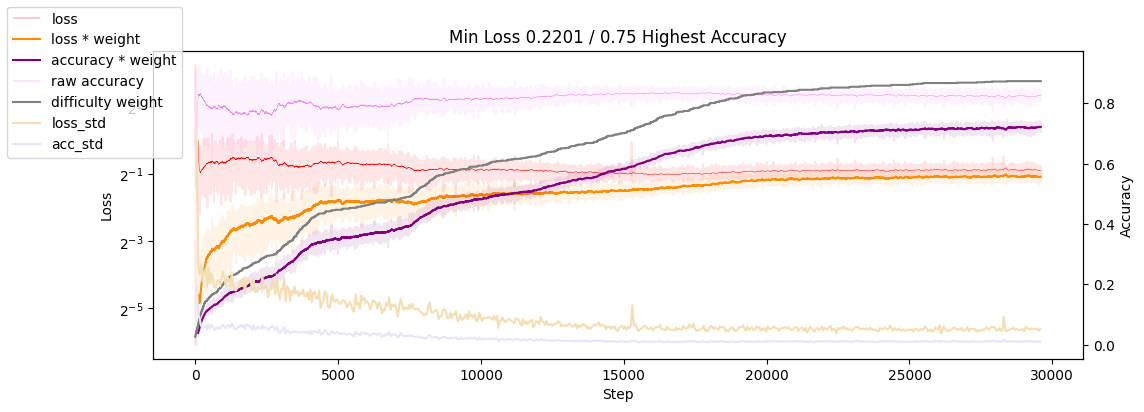

learning_rate 0.01
    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     1     2     2     9    49   182   549  1506  3664  7575 13669 21763 30177 36480 35942 28428 16092  6431  max = 38
 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.01  0.02  0.04  0.07  0.11  0.15  0.18  0.18  0.14  0.08  0.03  

averaged loss -> mean_prev:0.5433 mean:0.5404

accuracy: 0.716 raw_acc: 0.820 with factor 0.87     - sample: acc:0.93 _ 37 correct
 0,  0,  0,  0,  0,  0,  4,  6,  3,  7, 11,  6, 11,  7, 11,  0, 10,  3, 11,  5, 11, 13,  8,  5, 12,  2,  6, 10,  0, 11, 11,  4,  5,  3, 14,  9,  8,  2, 14,  1, 
 0,  0,  0,  0,  0,  0,  4,  6,  3,  7, 11,  6, 11,  7, 11,  0, 10,  2, 11,  5, 11, 13,  8,  5, 12,  2,  6, 10,  0, 11, 11,  4,  5,  2, 14,  9,  8,  2, 14, 14, 

~ ~ ~  loss_std:0.0525 acc_std:0.0115  ~ ~ ~

accuracy: 0.

In [ ]:
# from itertools import product
from itertools import chain, tee

experiment_counter = 0
for hp_n_latent, hp_n_step in chain(
    loop_over_extremum(exp_cfg.n_latent, exp_cfg.n_step, corner=True,  edge=False),
    loop_over_extremum(exp_cfg.n_latent, exp_cfg.n_step, corner=False, edge=True),
    ):
    experiment_counter += 1
    # if experiment_counter<21:
    #     continue
    # if hp_n_latent>5:
    #     break
    # if hp_n_step!=1:
    #     continue

    read_step = hp_n_step - 1 # remove on output step
    # if read_step<1:
    #     continue

    # make model
    model = ToyThinker(**model_cfg.__dict__).to(device)
    # model = torch.compile(model)

    # init tracker
    loss_tracker = []
    acc_tracker = []
    match_counter = MatchCount(20+1+20)
    best_loss = float('inf')

    # init optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=run_cfg.learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.0005, verbose=True)

    # init dataset/loader
    data_cfg.batch = run_cfg.batch
    # dataset = NumbersComputeDataset(data_cfg)
    dataset = NumbersCopyDataset(**data_cfg.__dict__)

    batch_size = 1 # 1024
    # dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=4, pin_memory=True)
    NumbersCopyDataset.reset()

    # reset before train
    optimizer.zero_grad()
    model.train()

    from time import time
    start_time = time()
    # for idx, (inputs,targets) in enumerate(dataloader):
    for idx, (inputs,targets) in enumerate(chain(*tee(dataset, 2))): # mini data loader :-)
        end_dataloading_time = time()
        # inputs,targets = inputs.to(device), targets.to(device)
        inputs,targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        # inputs,targets = inputs[0].to(device, non_blocking=True), targets[0].to(device, non_blocking=True)
        batch_size = inputs.size(0)

        n_latent = CfgNode.sample_(hp_n_latent)
        n_step   = CfgNode.sample_(hp_n_step)

        #### Toy model
        # with torch.autocast(device_type="cpu", dtype=torch.bfloat16):
        n_target = targets.size(1)
        logits, output_probe = model(inputs, n_latent, n_target, n_step, read_step) # n_keep_output=1, n_memory=1e4

        # compute loss
        logits, output_probe = logits[:,0,:,:], output_probe[:,0,:,0] # .permute(0,-1,1,2) or (0,3,1,2)
        output_loss = torch.nn.functional.cross_entropy(logits.permute(0,2,1), targets.long())#, ignore_index=20)
        # probe_loss = torch.nn.functional.mse_loss(output_probe, targets.float()/2)
        end_forward_loss_time = time()

        # various training observers and controls
        accuracy = (targets == torch.argmax(logits, dim=2)).float().mean().item()
        match_counter.update(logits, targets)

        # curriculum learning
        NumbersCopyDataset.update_accuracy(accuracy)
        factor =  NumbersCopyDataset.get_challenge_factor()
        NumbersCopyDataset.raw_acc = accuracy
        raw_acc = accuracy
        accuracy = accuracy * factor
        if idx%51==0:
            s = np.random.randint(targets.size(0))
            correct = (targets[s,:] == torch.argmax(logits[s,:], dim=1)) #[:break_i]
            print()
            print("accuracy: %.3f raw_acc: %.3f with factor %.2f     - sample: acc:%.2f _ %d correct" % (accuracy, raw_acc, factor, correct.float().mean(), correct.sum(),))
            for i in range(targets.size(1)):
                val = targets[s,i].item()
                print(f"{val:2d}", end=', ')
                # if val == 20: break
            print()
            for j in range(i+1):
                val = torch.argmax(logits[s,j]).item()
                print(f"{val:2d}", end=', ')
            print()
            # for j in range(i+1):
            #     val = outputs_probe[s,j].item()*16
            #     print(f"{val:.2f}", end=', ')
            # print()


        # (output_loss + probe_loss).backward()
        output_loss.backward()

        if idx%1==0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            optimizer.zero_grad()
            # scheduler.step()
        if idx%100==0:
            # print(f"{idx} :: loss: {output_loss.item():.4f}, n_step: {n_step}, latent_size: {latent_size}")
            print(f"id: {idx:3d}: loss: {output_loss.item():.3f} accuracy: {accuracy:.2f}")

        std = dict()
        if idx%51==0:
            loss_std = np.std(loss_tracker[-50:]) / np.mean(loss_tracker[-50:])
            acc_std  = np.std(acc_tracker[-50:])  / np.mean(acc_tracker[-50:])
            std = dict(loss_std=loss_std, acc_std=acc_std)
            print(f"\n~ ~ ~  loss_std:{loss_std:.4f} acc_std:{acc_std:.4f}  ~ ~ ~")
            # if loss_std>0.1:
            #     scheduler.step()

        # loss_tracker.append(outputs_probe_loss.item())
        loss_tracker.append(output_loss.item())
        acc_tracker.append(accuracy)
        logs.append(dict(
            loss = output_loss.item(),
            # probe_loss = probe_loss.item(),
            accuracy = accuracy,
            latent = n_latent,
            step = n_step,
            iteration = idx,
            experiment = experiment_counter,
            factor = factor,
            raw_acc = raw_acc,
            **std
        ))

        if idx%400==0 and idx>=100:
            from IPython.display import clear_output
            clear_output()

            print(f"exp:{experiment_counter}, n_latent:{n_latent}, n_step:{n_step}")
            plot_loss_and_accuracy(logs, y_log=True)
            # plot_hp_heatmap(logs, aggr='max')
            plt.show()

            # with open('./train_param.txt','r') as f:
            #     lr = float(f.read())*learing_rate

            # print('========== learing_rate:', lr)
            # for param_group in optimizer.param_groups:
            #     param_group['lr'] = lr

            print('learning_rate', optimizer.param_groups[0]['lr'])
            print(match_counter,'\n')
            match_counter = MatchCount(20+1+20)

            mean = np.mean(loss_tracker[-50:])
            mean_prev = np.mean(loss_tracker[-100:-50])
            print(f'averaged loss -> mean_prev:{mean_prev:.4f} mean:{mean:.4f}')

        # if idx%100==0 and idx>=100:
        #     mean_loss = np.mean(loss_tracker[-100:])
        #     if mean_loss < best_loss:
        #         best_loss = mean_loss
        #         torch.save(model.state_dict(), "model.pt")
        #         print(f'save best model mean_loss={mean_loss:.4f}')
        #     # scheduler.step()

        # if idx%200==0 and idx>=200:
        #     mean_loss = np.mean(loss_tracker[-200:])
        #     if mean_loss > best_loss:
        #         print('loss increase, load best model')
        #         model.load_state_dict(torch.load("model.pt"))
        #         # scheduler.step()

        # if idx>=200 and (loss_tracker[-1]/loss_tracker[-10])>1.5:
        #     print('loss peak increase, load best model')
        #     model.load_state_dict(torch.load("model.pt"))
        #     # scheduler.step()

        if idx%101==0:
            print(f"Timing\n"
                f"{end_dataloading_time-start_time:.6f} data loading\n"
                f"{end_forward_loss_time-end_dataloading_time:.6f} forward+loss\n"
                f"{time()-end_forward_loss_time:.6f} backward+remaining\n"
            )
            # !nvidia-smi

        if idx>run_cfg.max_iter:
            break
        start_time = time()


In [ ]:
import pandas as pd

df = pd.DataFrame(logs)
# df.to_csv('logs-copy-hdim16-9k_param-20Dec.csv', index=0)

In [ ]:
df.columns

In [ ]:
# @title
import pandas as pd
import seaborn as sns

def plot_loss_and_accuracy(logs, experiment=None, title=None):
    # Create a DataFrame from the list of dictionaries.
    if isinstance(logs, pd.DataFrame): df = logs
    else: df = pd.DataFrame(logs)

    # Filter current experiment
    if 'experiment' in df.columns:
        if experiment == None:
            experiment = df.iloc[-1].experiment
        df = df[df.experiment == experiment]

    # Plot the loss values on the left y-axis.
    sns.lineplot(data=df, x='iteration', y='loss', color='orange') #, hue='step')
    # sns.lineplot(data=df, x='iteration', y='probe_loss', color='peru') #, hue='step')
    plt.ylabel('Loss')
    # plt.yscale('log',base=2)

    # Plot the accuracy values on the right y-axis.
    plt.twinx()
    sns.lineplot(data=df, x='iteration', y='accuracy', color='purple') #, hue='latent')
    plt.ylabel('Accuracy')

    # Set the title of the plot.
    if title: plt.title(title)
    else: plt.title('Loss and Accuracy')
    plt.xlabel('Step')


    # Set the width of the plot.
    plt.gcf().set_size_inches(12, 4)

    # Show the plot.
    plt.show()

    #plot_hp_heatmap(logs)

def plot_hp_heatmap(logs, use_last_n_batch=200, aggr='max'):
    if isinstance(logs, pd.DataFrame): df = logs
    else: df = pd.DataFrame(logs)

    if len(df)<use_last_n_batch: return

    # Group the data by the latent and step columns.
    # df = df[-use_last_n_batch:].groupby(['latent', 'step'])
    df = df.groupby(['latent', 'step'])
    if aggr=='mean':
        df = df.mean()
    elif aggr=='max':
        df = df.max()
    else:
        assert f'Invalid argument aggr={aggr}'
    df = df.reset_index().pivot(index="latent", columns="step", values="accuracy")

    # if len(df)<2: return #not interresting
    # print('i')

    # Plot a heatmap of the average loss.
    sns.heatmap(df, annot=True)

    # Show the plot.
    plt.show()


for exp_id in df.experiment.unique():
    df_exp = df[df.experiment==exp_id]
    step, latent = df_exp.iloc[0].step, df_exp.iloc[0].latent
    title = f"Loss and Accuracy w/ hyperparam = step: {step:.0f} | latent: {latent:.0f}"
    plot_loss_and_accuracy(df_exp, None, title=title)

# plot_hp_heatmap(df, aggr='max')

In [ ]:
def compare_experiments(logs):
    if isinstance(logs, pd.DataFrame): df = logs
    else: df = pd.DataFrame(logs)

    unique_experiments = df.experiment.unique()
    num_experiments = len(unique_experiments)

    fig = plt.figure(figsize=(25, 15))

    # Create a 2x2 grid with the heatmap at the center
    grid = GridSpec(5, 4, figure=fig)
    heatmap_ax = plt.subplot(grid[1:-1, 1:-1])
    plot_hp_heatmap(df, aggr='max', ax=heatmap_ax)

    for i, exp_id in enumerate(unique_experiments):
        df_exp = df[df.experiment == exp_id]
        step, latent = int(df_exp.iloc[0].step), int(df_exp.iloc[0].latent)
        title = f"Loss and Accuracy w/ hyperparam = step: {step:.0f} | latent: {latent:.0f}"
        plot_loss_and_accuracy(df_exp, None, title=title, ax=plt.subplot(grid[latent-4, step-1]))


    # # Set the figure size for each subplot
    # for ax in [heatmap_ax] + loss_accuracy_axs:
    #     box = ax.get_position()
    #     ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()



In [ ]:
plot_hp_heatmap(logs)

In [ ]:
logits.shape, logits[:,0,:,:].permute(0,2,1).shape, targets.shape # output_probe.shape

In [ ]:
output_loss = torch.nn.functional.cross_entropy(logits[:,0,:,:].permute(0,-1,1,2), targets.long())

In [ ]:
logits.shape

In [ ]:
output_probe.shape

In [ ]:
# def train(r_cfg, dataset, model):

In [ ]:
data_cfg.batch = run_cfg.batch
dataset = NumbersComputeDataset(data_cfg)

# dataset = NumbersCopyDataset(low=0, high=16, size=(20,), flip=False, roll=True, sort=False)
# dataset = NumbersComputeDataset(TASK_SCHEME)

train(run_cfg, dataset, model)

# end of training

In [ ]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

# Generate some sample data similar to your post
n = len(loss_tracker)
X = np.arange(1,n+1)
Y = np.array(acc_tracker)

Y2 = savgol_filter(Y, 1000, 3)

i = 0 # 10000
plt.figure(figsize=(12,5))
plt.plot(X[i:],  Y[i:], linestyle='-', linewidth=2,alpha=.5)
# plt.plot(X[i:], Y2[i:], color='r')
plt.yscale('log',base=10)
plt.xscale('log',base=10)
plt.gca().invert_xaxis()

plt.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig=px.line(x=X,y=Y2, log_y=True)
fig.add_scatter(x=X, y=Y, mode='lines')
fig.show()